# Test File - Pushing to Git

Git use is successful - set up and saving ok.

# Aims for this notebook:
- Import data from the scan feature in ImageJ
- Plot data (normalise) and fit to Gaussians to find waist values 
- Plot all waist values against z distance to extropolate back and find w0

## Import all useful libraries / tools

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

## Import Data

Function below that takes path and returns distances and amplitudes from all csv files in that folder, as np.ndarrays in a big list

In [52]:
def import_data(global_path):

    # Function which finds filenames of csvs in a folder
    def find_csv_filenames( path_to_dir, suffix=".csv" ):
        filenames = listdir(path_to_dir)
        return [ filename for filename in filenames if filename.endswith( suffix ) ]

    # the list of files in the folder
    files_list = find_csv_filenames(global_path)

    # empty lists to put values in
    distances = []
    amps = []

    # loop through file names in directory
    for f in range(len(files_list)):

        # Import an execl sheet as dataframe, called 'Values1'
        # NB: Image J seems to have saved this 'excel sheet' as a csv file
        df_test = pd.read_csv(global_path + files_list[f])

        # Extracing a column by title and converting data to array
        distances.append(np.array(df_test['Distance_(microns)']))
        amps.append(np.array(df_test['Gray_Value']))

    # returning arrays within two big lists
    return distances, amps

In [53]:
# Define useful path to data
globalpath = "D:/1. L4 Project/Fibres/2023-11-28/Data-Photo2/"

In [54]:
distances, amplitudes = import_data(globalpath)

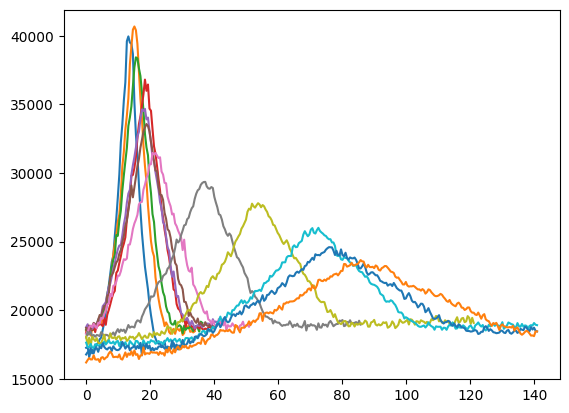

In [55]:
for i in range(12):
    plt.plot(distances[i][0:300], amplitudes[i][0:300])

plt.show()

## Normalise, cut down data

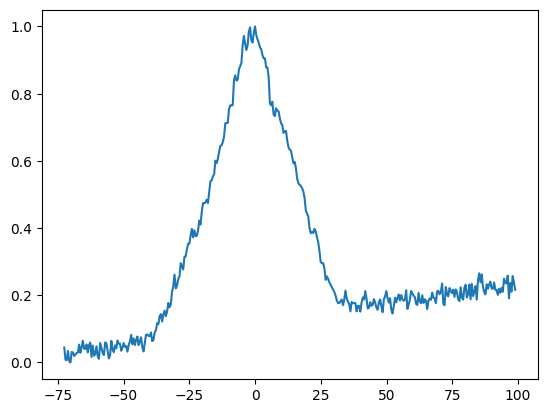

In [56]:
index = 9
#cutoff = int(320)

cutoff_array = np.ones(12)*300

# Get rid of vertical offset - to reduce a fitting parameter
subt_amp = amplitudes[index] - np.min(amplitudes[index])

# Normalise data by its maximum value
norm_amp = subt_amp / np.max(subt_amp)

dist_max = 0

# Move data so centred on zero - reduce fitting params further
for i in range(norm_amp.size):
    if norm_amp[i] == np.max(norm_amp):
        dist_max = distances[index][i]

shifted_distances = distances[index] - dist_max

plt.plot(shifted_distances, norm_amp)

## Fit Data

In [57]:
# Redefining x and y
x = shifted_distances
y = norm_amp

Defining useful functions - using chi squared and fit_labs, previously written

In [58]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

In [59]:
def fit_labs(xdata,ydata, yerrors, function, initial_guess):

    dof = np.size(xdata) - np.size(initial_guess) ## degrees of freedom

    if np.size(yerrors) == 1:

        yerr_extended = np.zeros(np.size(xdata))
        for i in range(np.size(yerr_extended)):
            yerr_extended[i] = yerrors

        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerr_extended, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    if yerrors == 0:

        parameters, covariance = curve_fit(function, xdata, ydata, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    else:
    
        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerrors, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    perrors = np.sqrt(np.diag(covariance))

    chisq_min = chi_squared(parameters,
                        function, 
                        xdata, 
                        ydata, 
                        yerrors) 
    
    chisq_reduced = chisq_min / dof

    p_value = scipy.stats.chi2.sf(chisq_min, dof)

    yfit = function(xdata, *parameters)

    return yfit, parameters, perrors, chisq_reduced, p_value, dof

In [60]:
def Gauss(x, W): ### Defien Gaussian with FOUR parameters 
    y = np.exp(-2*x**2 / W**2)
    return y

In [61]:
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(x,y, 0, Gauss, 25)

c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:504: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
C:\Users\abiga\AppData\Local\Temp\ipykernel_368\611882542.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)
C:\Users\abiga\AppData\Local\Temp\ipykernel_368\611882542.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)


[33.13111961] [4.84588831] nan


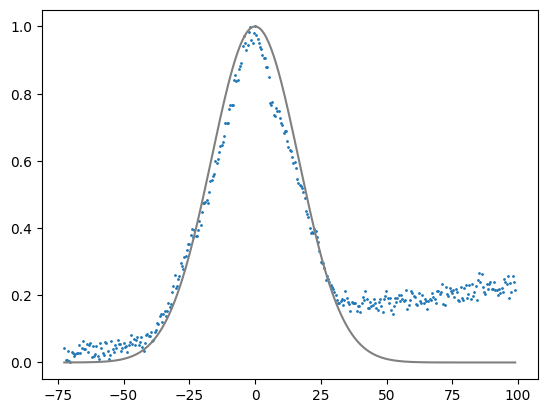

In [66]:
plt.scatter(x,y, s = 1)
plt.plot(x,yfit, color = 'grey')
print(parameters, perrors, chisq_reduced)